In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange

import os
import gc
import sys
import h5py
import pickle
import numpy as np
import itertools as it
from tqdm.auto import trange,tqdm
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.dirname(os.getcwd())+'/PDGNet')
import sysmodels as sysm
from sysmodels import WirelessModel, patternnet
import utils #from utils import train, predict, initnw, weighted_selected_error_eval
from baselines import pa_orthog
from federated import *

# B = 180e3
# N0 = 1e-3 * 10**(-174/10)
# F = 10**(3/10)
# noise = B*N0*F
# noise

## load data

In [ ]:

interf_scale = 1 # scale interference
i0 = 20 # which pmax

L = 8
n_ant = 10#2
M = 1#4
tr_dist = 'Alessio' # Alessio | HataSuburban | HataSuburban-noSF | HataUrban | HataUrban-noSF
te_dist = 'Alessio'

device = torch.device('cuda')
MODL_RT = "/root/wireless-fl-icassp/results/]archive/models-nr10-pdg/"
DATA_RT = "/root/wireless-fl/data/"

####################################################
####################   DATA   ######################
####################################################

B = 1
m = 0.023
pdb = np.array(range(-40,10+1,1))
indexing = np.delete(np.arange(L**2), np.arange(L**2)[::L+1])

# add initial pt (max)
attach_pt = lambda x: torch.from_numpy(np.hstack((utils.init_p(x[:,-1], L, method="full"), x))).float().to(device)

# move channel info to device
dict_to_device = lambda x,dev: {k:v.to(dev) if isinstance(v, torch.Tensor) else v for k, v in x.items()}

X, y, cinfo = {},{},{}
for phase in ['tr','val','test']:
    sufix = '' if phase=='tr' else phase+'-'
    dfn = DATA_RT + f"bs+{M}_ant+{n_ant}/{sufix}channels-{tr_dist}-{L}-1000.h5" # train / validation data
    X[phase],y[phase],cinfo[phase] = utils.load_data_unsup(dfn, hxp=False, num_stab=1e-12, PdB=pdb)
    
    X[phase] = attach_pt(X[phase])
    X[phase][:,L:-1][:,indexing]*=interf_scale 
    
    cinfo[phase] = dict_to_device(cinfo[phase], device)
    print(phase, X[phase].shape, y[phase].shape)


ph = 'test'
H_mat = X[ph][i0::len(pdb),L:-1].cpu().numpy().reshape(-1,L,L) #* noise
p_max = X[ph][i0::len(pdb),-1].cpu().numpy().reshape(-1)
h_all = np.vstack([np.diag(H) for H in H_mat])
beta_all = np.array(H_mat) 
for bi, b in enumerate(beta_all):
    for i in range(b.shape[0]):
        beta_all[bi, i, i]=0
        

FINALERROR = {}
curr_task = 'AirQuality' # AirQuality | MNIST

## for mnist classification

In [81]:
    

if curr_task == 'MNIST':
    
    datanumber=(np.random.RandomState(42).randint(100,1000,L ) * 5).astype(int) #np.array([1000]*10)
    k_weights = datanumber/datanumber.sum()

    averagenumber = 10  ## Number of implementation of FL
    iteration     = 50  ## Number of iterations for each FL implementation

    numberofneuron = 50
    in_size        = 784
    out_size       = 10
    msize = in_size*numberofneuron + numberofneuron*out_size + (numberofneuron+out_size) #=39760
    Z = msize * 16 / 1024 / 1024    # Data size of each FL model, we assume that each element occupies 16 bits 
    sysmodel = WirelessModel(bandwidth=B)

    drequirement = Z / 0.7 ## delay requirement
    erequirement = Z / 55  ## energy requirement

    # MINST data processing
    batch_size_train = 16
    batch_size_test = 1000
    
    train_set, test_set = utils.load_mnist('./datasets/')



## for air quality reggression

In [83]:

if curr_task == 'AirQuality':

    datanumber=(np.random.RandomState(42).randint(100,1000,L ) / 5).astype(int) #np.array([1000]*10)
    k_weights = datanumber/datanumber.sum()

    averagenumber = 15  # Number of implementation of FL
    iteration     = 50  # Number of iterations for each FL implementation

    numberofneuron = 50
    in_size        = 8
    out_size       = 1
    msize = in_size*numberofneuron + numberofneuron*out_size + (numberofneuron+out_size) #=39760
    Z = msize * 16 / 1024 / 1024;    # Data size of each FL model, we assume that each element occupies 16 bits 
    sysmodel = WirelessModel(bandwidth=B)

    drequirement = Z / 0.7  # delay requirement
    erequirement = Z / 55   # energy requirement

    # UCI AQ data processing 
    random_seed = 1
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)

    data_all  = pickle.load(open('./datasets/AirQualityUCI_proccessed.p','rb'))
    batch_size_train = 8
    batch_size_test = data_all['ntest']

    class AirQualityDataset(torch.utils.data.Dataset):
        """Face Landmarks dataset."""

        def __init__(self, x, y):
            """
            Args:
                csv_file (string): Path to the csv file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied
                    on a sample.
            """
            self.data = x
            self.targets = y

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx],self.targets[idx]

    train_set = AirQualityDataset(data_all['X_train'], data_all['y_train']) # training data
    test_set  = AirQualityDataset(data_all['X_test'] , data_all['y_test']) # test data


In [84]:
inputs = {
    'channels': (h_all, beta_all, p_max),
    'fedtask' : (test_set, train_set, batch_size_train),
    'require' : (drequirement, erequirement),
    'configs' : (numberofneuron, in_size, out_size), # fed network configs
}
datanumber.sum()

672

## ideal FL

In [85]:
FINALERROR['Ideal FL'], global_net, num_sel = FL_main(
    inputs        = inputs,
    fl_task       = curr_task, #'AirQuality', 'MNIST',
    allocation_scheme = 'Ideal FL',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration, 
    iter_epochs   = 1,
    iter_iters    = iter_iters,
    averagenumber = averagenumber,
    seed          = 0
)

49 44 0.869326865140961  
Error at iter#50 is 0.8583758354466257


49 37 0.8550991496659495 
Error at iter#50 is 0.8550991496659495


49 40 0.8716922978765366 
Error at iter#50 is 0.854376701180272


49 42 0.862138673866111  
Error at iter#50 is 0.8511934793224322


49 46 0.8701893854639327 
Error at iter#50 is 0.8591148329440831


49 35 0.8846652413993724 
Error at iter#50 is 0.8724562932410284


49 10 0.8788603707100926 
Error at iter#50 is 0.8561407437196253


49 47 0.8909177800849131 
Error at iter#50 is 0.8421064192715351


49 3 0.8663443513159579  
Error at iter#50 is 0.8565627814608713


49 28 0.8883045820864176 
Error at iter#50 is 0.8656458167041627


49 9 0.8700895123088955  
Error at iter#50 is 0.8547373392752338


49 25 0.8657796618287494 
Error at iter#50 is 0.8582151735941965


49 11 0.8643379131202671 
Error at iter#50 is 0.8631958725081075


49 18 0.864236708561192  
Error at iter#50 is 0.858589541673977


49 43 0.8695594035866478 
Error at iter#50 is 0.8620408411617759



Predicted air quality: 4.8878984451293945
Actual air quality: tensor([6.])


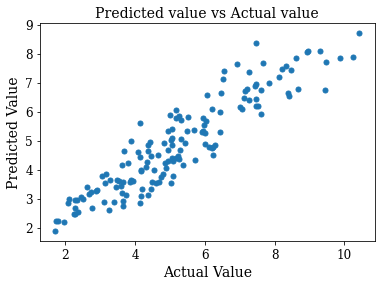

In [9]:
if curr_task == 'AirQuality':
    net = global_net
    sample_tensor = test_set.data[[23]]
    y_pred = net.model(sample_tensor)
    print(f'Predicted air quality: {y_pred.item()}')
    print(f'Actual air quality: {test_set.targets[23]}')

    y_pred_tensor = net.model(test_set.data) # test predictions on full model
    y_pred = y_pred_tensor.detach().numpy() # detach and convert to np array

    plt.scatter(test_set.targets, y_pred)
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.title("Predicted value vs Actual value")
    plt.show()

## RAND POWER

In [10]:
FINALERROR['Rand'], global_net_rand, num_sel_rand = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'Rand',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration,
    iter_epochs   = 1,
    averagenumber = averagenumber,
    seed          = 0
    )

49 44 4.058498113421455  
Error at iter#50 is 1.9749011268493135


49 37 4.9256184223558535 
Error at iter#50 is 2.5960480953751564


49 40 3.790329554177639  
Error at iter#50 is 2.124506837054119


49 42 3.150671533121017  
Error at iter#50 is 1.476506550046742


49 46 2.2890505220796364 
Error at iter#50 is 1.1155688423960841


49 35 4.659800155349258  
Error at iter#50 is 1.5122559847127603


49 10 2.8308825458616886 
Error at iter#50 is 2.2017936200780173


49 47 4.1220516881316405 
Error at iter#50 is 1.3996286274306877


49 3 2.184020408479124   
Error at iter#50 is 1.749072169525424


49 28 2.2942825530694977 
Error at iter#50 is 2.2942825530694977


49 9 3.4825802957954317  
Error at iter#50 is 2.089625381041602


49 25 4.452198668387124  
Error at iter#50 is 2.5752686369680484


49 11 1.6420220376091237 
Error at iter#50 is 1.1803655128602708


49 18 3.9570953574829217 
Error at iter#50 is 2.261874020637665


49 43 2.6891676585744615 
Error at iter#50 is 1.3796744651653907



## ORTH POWER

In [11]:
FINALERROR['Orth'], _, num_sel_orth = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'Orth',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration,
    iter_epochs   = 1,
    averagenumber = averagenumber,
    seed          = 0
)


49 44 3.415256178087215  
Error at iter#50 is 2.3841615953850392


49 37 3.5599007744837388 
Error at iter#50 is 1.2515010404319569


49 40 3.5533914404072857 
Error at iter#50 is 1.6113370767980506


49 42 3.723305740618484  
Error at iter#50 is 1.1954550066003262


49 46 3.765582958952299  
Error at iter#50 is 1.4655005038158706


49 35 3.603284444862545  
Error at iter#50 is 1.2037164299582879


49 10 3.764946967532871  
Error at iter#50 is 1.7811027599849416


49 47 3.466134399731487  
Error at iter#50 is 1.5269162099166815


49 3 2.8127539626007065  
Error at iter#50 is 1.5890572966993994


49 28 106.58964097181301 
Error at iter#50 is 2.0656428810996226


49 9 4.5358303728899365  
Error at iter#50 is 1.1783283816983985


49 25 3.726530126914876  
Error at iter#50 is 2.2935815151607346


49 11 3.8713796377231517 
Error at iter#50 is 1.1625653566426173


49 18 60.33628093340689  
Error at iter#50 is 1.8405500542451996


49 43 2.878664252411662  
Error at iter#50 is 1.3413874238814325



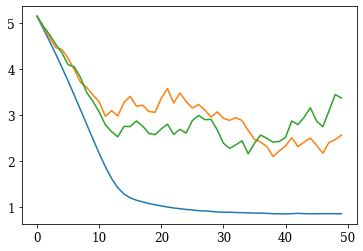

In [12]:
[FINALERROR[k].sort(0) for k in FINALERROR.keys()]
        
tot1, tot2 = 8, 50
plt.plot(FINALERROR['Ideal FL'][:tot1].mean(0)[:tot2])
plt.plot(FINALERROR['Rand'][:tot1].mean(0)[:tot2])
plt.plot(FINALERROR['Orth'][:tot1].mean(0)[:tot2])
# plt.yscale('log')


## MLP & GCN

In [13]:
def per_from_learning_models(modeldir, numworker):
    ## load model
    mfile = modeldir + 'model_pd.pt'
    mfilev = modeldir + 'model_pd-vio.pt'

    inputdir_test = {
        'Hx_dir':{
            'Hx':X['test'][i0::51, :], 
            'edge_index':cinfo['test']['edge_index']
        }, 
        'B':1, 
        'm':0.023
    }
    try:
        model = torch.load(mfile)
    except:
        model = torch.load(mfilev)
    model.eval()    

    model.model.size = L
    with torch.no_grad():
        pt = model.allocate(inputdir_test['Hx_dir'])
    finalq = sysm.f1(pt, inputdir_test['Hx_dir']['Hx'], inputdir_test['m'])
    finalq_cond = (1-finalq*(pt>0)).cpu().numpy()   
    return finalq_cond
    

In [14]:
## MLP
modeldir = MODL_RT + f'Alessio_Ant+10_User+8_MLP_Intfx1_Pmax-20_Constr+c+e_seed+42/'

finalq_mlp = per_from_learning_models(modeldir, L)

FINALERROR['PDM'], _, num_sel_mlp = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'PD-MLP',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration, 
    iter_epochs   = 1,
    averagenumber = averagenumber,
    per_ready     = finalq_mlp,
    seed          = 0
)


49 44 0.9553462863147374 
Error at iter#50 is 0.9553462863147374


49 37 2.6094066138265495 
Error at iter#50 is 1.1328957362671639


49 40 1.9619407367174675 
Error at iter#50 is 1.0511840275260809


49 42 1.5772110964962067 
Error at iter#50 is 0.9355133624037456


49 46 1.7264867567476374 
Error at iter#50 is 0.9161147854943812


49 35 2.0514087116738935 
Error at iter#50 is 1.1885919569755943


49 10 1.067183326724202  
Error at iter#50 is 1.067183326724202


49 47 0.9815168515982359 
Error at iter#50 is 0.9815168515982359


49 3 1.9800816144402635  
Error at iter#50 is 1.0894450890760012


49 28 2.955466981706284  
Error at iter#50 is 1.091786338468696


49 9 1.014875340722557 2 
Error at iter#50 is 1.014875340722557


49 25 3.3041543011876926 
Error at iter#50 is 1.833617802426827


49 11 2.8587507389869953 
Error at iter#50 is 1.1303514252304763


49 18 1.661628483238234  
Error at iter#50 is 1.1523436982752902


49 43 2.6021214706602938 
Error at iter#50 is 1.1627036746861963



## GCN

In [15]:
## GCN
modeldir = MODL_RT + f'Alessio_Ant+10_User+8_GCN_Intfx1_Pmax-20_Constr+c+e_seed+42/'

finalq_gcn = per_from_learning_models(modeldir, L)

FINALERROR['PDG'], _, num_sel_gcn = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'PD-GCN',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration, 
    iter_epochs   = 1,
    averagenumber = averagenumber,
    per_ready     = finalq_gcn,
    seed          = 0
)

49 44 2.239811079880057  
Error at iter#50 is 0.9106839332544754


49 37 1.0405694459858268 
Error at iter#50 is 0.9396778876748905


49 40 0.889736870433275  
Error at iter#50 is 0.8796349111662428


49 42 2.8613397903985756 
Error at iter#50 is 0.9043247226851652


49 46 0.9092850670144927 
Error at iter#50 is 0.9092850670144927


49 35 1.8522075704378889 
Error at iter#50 is 0.8875197435251467


49 10 0.9045596307442669 
Error at iter#50 is 0.9045596307442669


49 47 0.9016151624402289 
Error at iter#50 is 0.8990036880409029


49 3 0.9088488180591557  
Error at iter#50 is 0.9083270244787598


49 28 0.8997908971850482 
Error at iter#50 is 0.8997908971850482


49 9 0.95277632917721 05 
Error at iter#50 is 0.95277632917721


49 25 0.8997708916449951 
Error at iter#50 is 0.8997708916449951


49 11 0.9583369165160046 
Error at iter#50 is 0.91507443224314


49 18 0.9651297326912495 
Error at iter#50 is 0.8753047821020629


49 43 0.9237546669786638 
Error at iter#50 is 0.9123925825150314



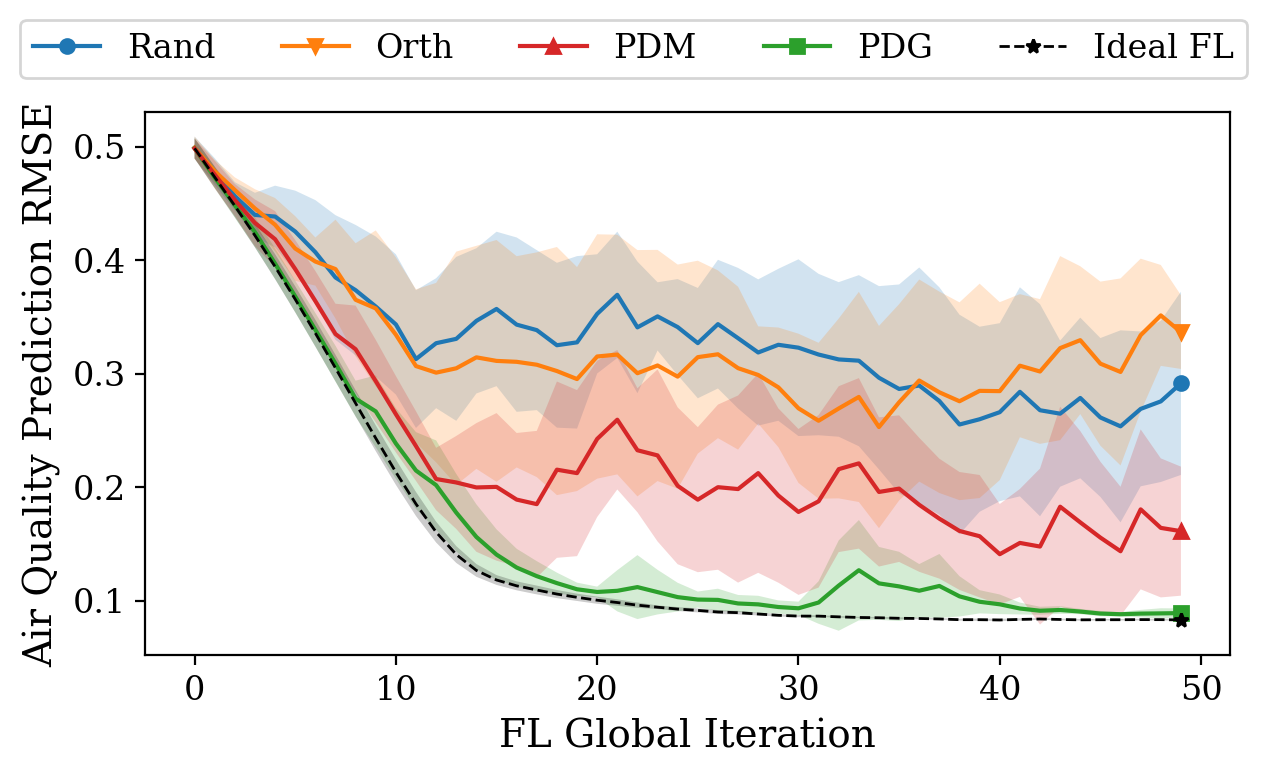

In [18]:

[FINALERROR[k].sort(0) for k in FINALERROR.keys()]
if curr_task == 'MNIST':
    ylabel_string = 'MNIST Prediction Error Rate'
    max_scale = 1
    y_limits = [None, .36]#[.14, .36]
else:
    ylabel_string = 'Air Quality Prediction RMSE'
    max_scale = test_set.targets.max()
    y_limits = None#[None, 0.62]
ff = 12

pnames = ['Rand','Orth','PDG','PDM','Ideal FL']

fig, ax = plt.subplots(figsize=(7,4),dpi=200)
markercycle = it.cycle(('o','v','s','^','*','+','x')) 
for li, lab in enumerate(pnames):
    vals = FINALERROR[lab][:ff].mean(0)
    color = next(ax._get_lines.prop_cycler)['color']
    marker = next(markercycle)
    
    vv = vals[:50]/max_scale
    if li < len(pnames)-1:
        ax.plot(vv, markevery=[len(vv)-1], marker=marker, color=color, lw=1.5, label=lab)
    else:
        color = 'black'
        ax.plot(vv, ls='--', color=color, markevery=[len(vv)-1], marker=marker, lw=1, label=lab)
        
    # error shade
    ss = (FINALERROR[lab][:ff]/max_scale).std(0)[:50]
    plt.fill_between(range(len(vv)), vv-ss, vv+ss, alpha=0.2, edgecolor='none', facecolor=color)

ax.set_ylim(y_limits)
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))

ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%d"))

ax.set_xlabel('FL Global Iteration')
ax.set_ylabel(ylabel_string)

# refine layout
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend()
handles, labels = ax.get_legend_handles_labels()
labels = pnames
ax.legend([handles[0], handles[1], handles[3], handles[2], handles[4]], 
          [labels[0], labels[1], labels[3], labels[2], labels[4]],
         loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=5)

plt.show()


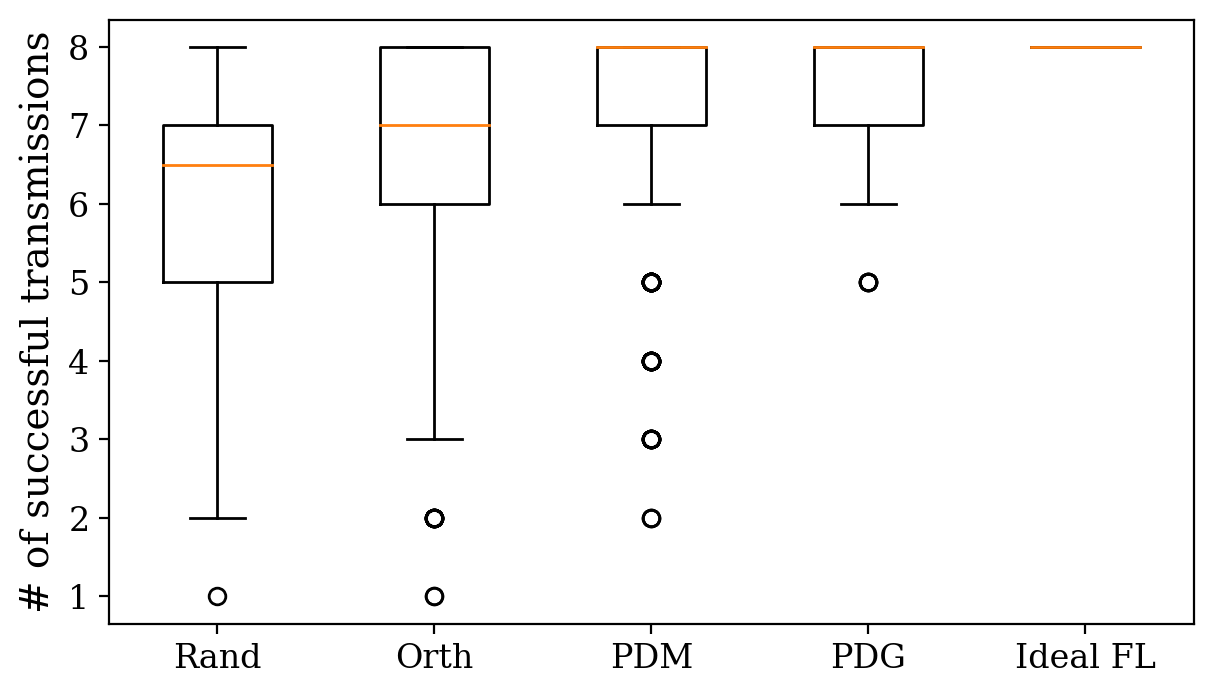

In [34]:
import pandas as pd
labels = ['Rand','Orth','PDM','PDG','Ideal FL']
num_sel_dict = dict(zip(['Rand','Orth','PDM','PDG','Ideal FL'], 
                        [d.sum(-1).flatten() for d in [num_sel_rand, num_sel_orth, num_sel_mlp, num_sel_gcn, num_sel]]))
df = pd.DataFrame.from_dict(num_sel_dict)

plt.figure(figsize=(7,4),dpi=200)
plt.boxplot(df[labels], labels=labels)
plt.ylabel("# of successful transmissions")
plt.show()